## Cheat Model
- Estimating a cheat model based on the performance of each model (predictivity)
- Comparing the cheat to average

In [36]:
import init_paths
import os
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.cio as cio
import Functional_Fusion.dataset as fdata
from scipy import stats
from statannotations.Annotator import Annotator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def apply_coef_to_models(train_types, coef_df):
    var_dic = {'eval_subj': [],
            'coef_var': [],
            'logalpha': [],
            'eval_dataset': []}
    applied_model = None
    for dataset_name, (train_ses, eval_ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=eval_ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id

        dirname=[]
        mname=[]
        dirname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg")
        mname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg_A{la}")

        fm,ti = rm.get_fitted_models(dirname,mname,config)
        if applied_model is None:
            applied_model = fm[0][0]
            applied_model.coef_ = np.zeros_like(applied_model.coef_)
        for s, conn_model in enumerate(fm[0]):
            applied_model.coef_ += conn_model.coef_ * coef_df[(coef_df.train_dataset==dataset_name) & (coef_df.logalpha==la)].reset_index().weight[s]
            var_dic['coef_var'].append(np.nanmean(conn_model.coef_var))
        var_dic['eval_subj'].extend(config["subj_list"])
        var_dic['logalpha'].extend([la]*(len(var_dic['coef_var'])-len(var_dic['logalpha'])))
        var_dic['eval_dataset'].extend([dataset_name]*(len(var_dic['coef_var'])-len(var_dic['eval_dataset'])))

    var_df = pd.DataFrame(var_dic)
    var_df['subj_id'] = var_df['eval_subj']
    var_df['train_dataset'] = var_df['eval_dataset']
    return applied_model, ti[0][0], var_df

In [3]:
def eval_group_model(train_types, dirname, mname, model, model_id):
    append = True
    for dataset_name, (train_ses, eval_ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset = dataset_name,
                                    eval_ses = eval_ses,
                                    eval_run='all',
                                    parcellation='Icosahedron1002',
                                    crossed = 'half', # "half", # or None
                                    type = "CondHalf",
                                    cerebellum='MNISymC3',
                                    splitby = None,
                                    add_rest = True,
                                    std_cortex='parcel',
                                    std_cerebellum='global',
                                    subj_list = 'all',
                                    model = model)
        dirnames=[]
        mnames=[]
        dirnames.append(dirname)
        mnames.append(mname)

        df, df_voxels = rm.eval_model(dirnames,mnames,config)
        save_path = gl.conn_dir+ f"/MNISymC3/eval"

        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        else:
            pass
        ename = config['eval_dataset']
        if config['eval_ses'] != 'all':
            ses_code = config['eval_ses'].split('-')[1]
            ename = config['eval_dataset'] + ses_code
        file_name = save_path + f"/{ename}_L2reg_{model_id}.tsv"
        if os.path.isfile(file_name) & append:
            dd = pd.read_csv(file_name, sep='\t')
            df = pd.concat([dd, df], ignore_index=True)
            # df = df.append(dd,ignore_index=True) # pd.append is deprecated
        df.to_csv(file_name, index = False, sep='\t')

In [22]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
eval_data = ["MDTBs2", "WMFS02", "Nishimoto02"]
models = []
for dataset_name in dataset_list:
    models.append(dataset_name+"-ind")
    models.append(dataset_name+"-loo")

df = rm.comb_eval(models=models,methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
df.loc[df.model.isna() & (df.train_dataset==df.eval_dataset) & (df.subj_id == df.eval_subj), 'model'] = 'same'
df.loc[df.model.isna() & (df.train_dataset==df.eval_dataset) & (df.subj_id != df.eval_subj), 'model'] = 'diff'
df.loc[df.model.isna() & (df.train_dataset!=df.eval_dataset), 'model'] = 'diff'

In [23]:
R_metric = "R_eval"

In [24]:
logalpha_list = [8, 10, 12]
diff_df = df[(df.model=='diff') & (df.logalpha.isin(logalpha_list))].copy()
mean_predictive = diff_df.groupby(['train_dataset', 'subj_id', 'logalpha'])[R_metric].mean().reset_index()
sum_coef_df = mean_predictive.groupby(['logalpha'])[R_metric].sum().reset_index()
sum_coef_df = sum_coef_df.rename(columns={R_metric: 'sum_weight'})
mean_predictive = pd.merge(mean_predictive, sum_coef_df, on='logalpha', how='left')
mean_predictive['weight'] = mean_predictive[R_metric] / mean_predictive['sum_weight']

In [25]:
la = 10
train_types = {
    'MDTB':        ('ses-s1',     'ses-s2',      la),
    'WMFS':        ('ses-01',     'ses-02',      la),
    'Nishimoto':   ('ses-01',     'ses-02',      la),
}

In [14]:
# Run this only if you haven't already
applied_model, ti, var_df = apply_coef_to_models(train_types, coef_df=mean_predictive)
cio.save_model(applied_model, ti, gl.conn_dir+"/MNISymC3/train/group_model/group_model_cheat_"+R_metric+"_la"+str(la))

avg_weight = mean_predictive.copy()
avg_weight['weight'] = 1 / avg_weight.groupby(['train_dataset', 'subj_id']).ngroups
applied_model, ti, var_df = apply_coef_to_models(train_types, coef_df=avg_weight)
cio.save_model(applied_model, ti, gl.conn_dir+"/MNISymC3/train/group_model/group_model_avg_"+R_metric+"_la"+str(la))

In [ ]:
# Run this only if you haven't already
eval_group_model(train_types, dirname='group_model', mname='group_model', model=["cheat_"+R_metric+"_la"+str(la)], model_id="group_cheat_"+R_metric)
eval_group_model(train_types, dirname='group_model', mname='group_model', model=["avg_"+R_metric+"_la"+str(la)], model_id="group_avg_"+R_metric)

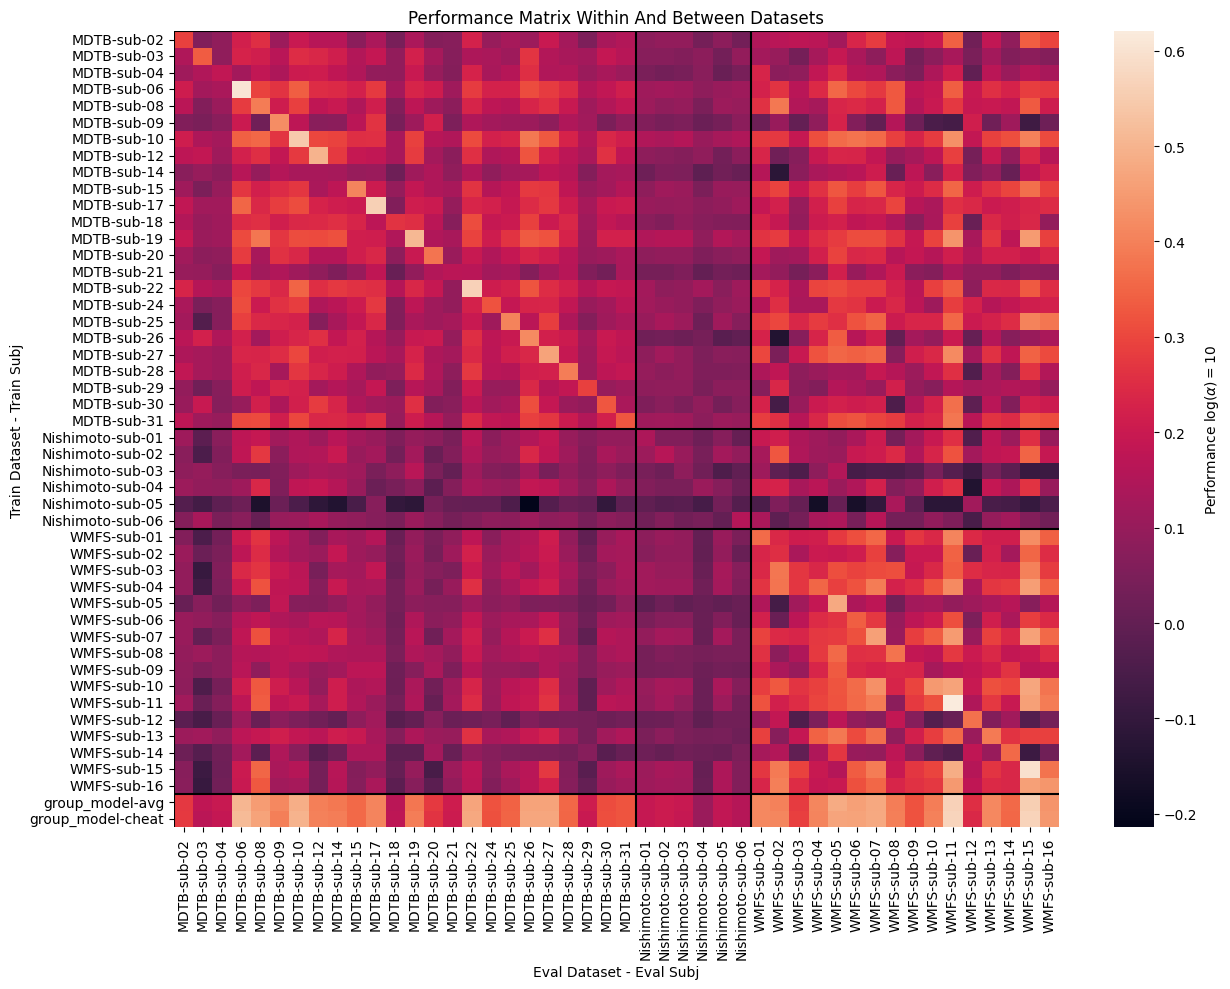

In [26]:
la = 10
df_cheat = rm.comb_eval(models=["group_cheat_"+R_metric],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
df_cheat['model'] = 'cheat'
df_cheat.subj_id = 'cheat'
df_cheat.train_dataset = 'group_model'

df_avg = rm.comb_eval(models=["group_avg_"+R_metric],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
df_avg['model'] = 'avg'
df_avg.subj_id = 'avg'
df_avg.train_dataset = 'group_model'

df_to_show = pd.concat([df[(df.logalpha==la) & ((df.model=='same')|(df.model=='diff'))], df_avg, df_cheat]).reset_index()
pivot_df = df_to_show.pivot_table(index=['train_dataset', 'subj_id'], columns=['eval_dataset', 'eval_subj'], values=R_metric, aggfunc='mean')

plt.figure(figsize=(13,10))
sns.heatmap(pivot_df, cbar_kws={'label': r'Performance $\log(\alpha)={}$'.format(la)})

eval_positions = [pivot_df.index.get_loc((eval_dataset, df_to_show[df_to_show['eval_dataset'] == eval_dataset]['eval_subj'].unique()[0])) for eval_dataset in df_to_show.eval_dataset.unique()]
train_positions = [pivot_df.index.get_loc((train_dataset, df_to_show[df_to_show['train_dataset'] == train_dataset]['subj_id'].unique()[0])) for train_dataset in df_to_show.train_dataset.unique()]
for posv in eval_positions:
    plt.axvline(x=posv, linewidth=1.5, color='black')
for posh in train_positions:
    plt.axhline(y=posh, linewidth=1.5, color='black')

plt.xlabel('Eval Dataset - Eval Subj')
plt.ylabel('Train Dataset - Train Subj')
plt.title('Performance Matrix Within And Between Datasets')
plt.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

avg_MDTB vs. cheat_MDTB: t-test paired samples, P_val:4.129e-01 t=-8.339e-01
avg_WMFS vs. cheat_WMFS: t-test paired samples, P_val:5.124e-01 t=-6.711e-01
avg_Nishimoto vs. cheat_Nishimoto: t-test paired samples, P_val:3.643e-01 t=9.976e-01


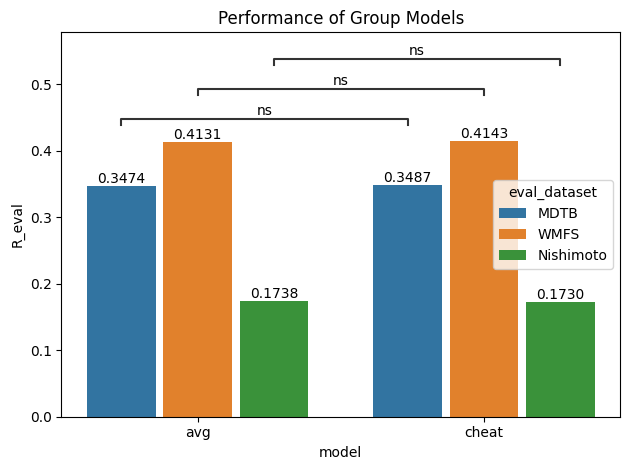

In [27]:
df_to_show = pd.concat([df_avg, df_cheat]).reset_index()
ax = sns.barplot(df_to_show, x="model", y="R_eval", hue="eval_dataset", dodge=True, gap=0.1 , errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.4f')
ax.bar_label(ax.containers[1], fmt='%.4f')
ax.bar_label(ax.containers[2], fmt='%.4f')
ax.set_title('Performance of Group Models')

# significance test
pairs = [(("avg", "MDTB"), ("cheat", "MDTB")),
         (("avg", "WMFS"), ("cheat", "WMFS")),
         (("avg", "Nishimoto"), ("cheat", "Nishimoto"))]
annotator = Annotator(ax, pairs, data=df_to_show, x='model', y='R_eval', hue='eval_dataset')
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.tight_layout()

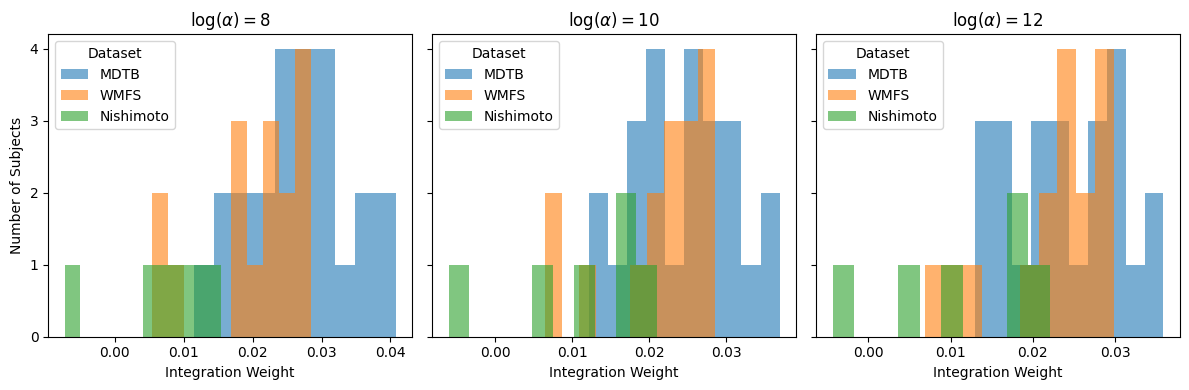

In [39]:
fig, axes = plt.subplots(1,3,figsize=(12,4), sharey=True)
for i, la in enumerate(mean_predictive.logalpha.unique()):
    ax = axes[i]
    df_to_show = mean_predictive[mean_predictive.logalpha == la]
    for dataset_name in dataset_list:
        ax.hist(df_to_show[df_to_show.train_dataset == dataset_name].weight, alpha=0.6, label=dataset_name)
    # ax.hist(df_to_show.weight, alpha=0.6)
    ax.set_xlabel('Integration Weight')
    if i==0:
        ax.set_ylabel('Number of Subjects')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(title='Dataset')
    ax.set_title(r'$\log(\alpha)={}$'.format(int(la)))
    # ax.set_xscale('log')
plt.tight_layout()